In [140]:
import pandas as pd
#import matplotlib as plt
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.genmod.families import Poisson

In [24]:
df_rodent = pd.read_csv('Rodent_Inspection_20240710.csv', nrows=2)

In [28]:
df_rodent.head()

,INSPECTION_TYPE,JOB_ID,BOROUGH,INSPECTION_DATE,RESULT
0,Initial,PC8122655,Manhattan,06/07/2023 04:36:13 PM,Passed
1,Initial,PC7504205,Staten Island,09/16/2010 04:00:00 PM,Failed for Other R
2,Initial,PC7744572,Bronx,07/28/2021 12:48:53 PM,Passed
3,Initial,PC7732344,Bronx,07/07/2021 08:49:45 AM,Passed
4,Initial,PC7906420,Bronx,07/19/2022 01:50:56 PM,Passed


In [53]:
df_restaurant = pd.read_csv('DOHMH_New_York_City_Restaurant_Inspection_Results_20240710.csv',
                            usecols=['CAMIS', 'BORO', 'ZIPCODE', 'INSPECTION DATE', 'VIOLATION CODE', 'VIOLATION DESCRIPTION', 'CRITICAL FLAG', 'SCORE', 'GRADE', 'GRADE DATE', 'INSPECTION TYPE'],
                            dtype={
                                'CAMIS' : str,
                                'BORO' : 'category',
                                'ZIPCODE' : 'category',
                                'INSPECTION DATE' : object,
                                'VIOLATION CODE' : 'category',
                                'VIOLATION DESCRIPTION' : str,
                                'CRITICAL FLAG': 'category',
                                'SCORE': float,
                                'GRADE' : 'category',
                                'GRADE DATE': object,
                                'INSPECTION TYPE': 'category'
                            })
df_restaurant['INSPECTION DATE'] = pd.to_datetime(df_restaurant['INSPECTION DATE'])
df_restaurant['INSPECTION GRADE DATE'] = pd.to_datetime(df_restaurant['GRADE DATE'])


In [63]:
df_rodent = pd.read_csv('Rodent_Inspection_20240710.csv',
                        usecols=['INSPECTION_TYPE', 'JOB_ID', 'BOROUGH', 'INSPECTION_DATE', 'RESULT', 'ZIP_CODE'],
                        dtype={
                            'INSPECTION_TYPE' : 'category',
                            'JOB_ID' : str,
                            'BOROUGH' : 'category',
                            'INSPECTION_DATE' : object,
                            'RESULT' : 'category',
                            'INSPECTION_DATE':object,
                            'ZIP_CODE' : 'category'
                        },
)
df_rodent['INSPECTION_DATE'] = pd.to_datetime(df_rodent['INSPECTION_DATE']
                                              , errors='coerce'
                                              , format='%m/%d/%Y %I:%M:%S %p')

## Clean Data

### Clean Restaurant Data

In [ ]:
df_restaurant.info()

In [54]:
df_restaurant = df_restaurant[(df_restaurant['INSPECTION DATE'].dt.year == 2019) 
                              & (df_restaurant['ZIPCODE'] not in ['12345', '08512'])
                              & (df_restaurant['ZIPCODE'].notna())
                              & (df_restaurant['SCORE'].notna()
                                 )]

In [57]:
df_restaurant.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2219 entries, 721 to 237205
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   CAMIS                  2219 non-null   object        
 1   BORO                   2219 non-null   category      
 2   ZIPCODE                2219 non-null   category      
 3   INSPECTION DATE        2219 non-null   datetime64[ns]
 4   VIOLATION CODE         2194 non-null   category      
 5   VIOLATION DESCRIPTION  2194 non-null   object        
 6   CRITICAL FLAG          2219 non-null   category      
 7   SCORE                  2219 non-null   float64       
 8   GRADE                  1283 non-null   category      
 9   GRADE DATE             1255 non-null   object        
 10  INSPECTION TYPE        2219 non-null   category      
 11  INSPECTION GRADE DATE  1255 non-null   datetime64[ns]
dtypes: category(6), datetime64[ns](2), float64(1), object(3)
memory

### Group the restaurant scores by zipcode and take the mean

In [129]:
df_restaurant_group = df_restaurant.groupby(by=['ZIPCODE']
                                            , dropna=False
                                            , observed=False
                                            , as_index=False).agg({
                                                'SCORE' : 'mean',
                                                'INSPECTION DATE' : 'count'
                                            })
df_restaurant_group.rename(columns = {'INSPECTION DATE' : 'count_restaurants'}, inplace=True)

In [127]:
df_restaurant_group

,ZIPCODE,SCORE,INSPECTION DATE
0,08512,NaN,0
1,10000,NaN,0
2,10001,13.055556,18
3,10002,15.096774,31
4,10003,19.687500,64
...,...,...,...
221,10115,NaN,0
222,10279,NaN,0
223,11550,NaN,0
224,14057,NaN,0


### Clean Rodent Data

In [65]:
df_rodent.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2584965 entries, 0 to 2584964
Data columns (total 6 columns):
 #   Column           Dtype         
---  ------           -----         
 0   INSPECTION_TYPE  category      
 1   JOB_ID           object        
 2   ZIP_CODE         category      
 3   BOROUGH          category      
 4   INSPECTION_DATE  datetime64[ns]
 5   RESULT           category      
dtypes: category(4), datetime64[ns](1), object(1)
memory usage: 51.8+ MB


In [130]:
df_rodent = df_rodent[(df_rodent['INSPECTION_DATE'].dt.year == 2019) 
                              & ~(df_rodent['ZIP_CODE'].isin(['0','10000','12345', '08512']))
                              & (df_rodent['ZIP_CODE'].notna())
                              ]

In [75]:
df_rodent.info()

<class 'pandas.core.frame.DataFrame'>
Index: 242747 entries, 7 to 2584959
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   INSPECTION_TYPE  242747 non-null  category      
 1   JOB_ID           242747 non-null  object        
 2   ZIP_CODE         242747 non-null  category      
 3   BOROUGH          242747 non-null  category      
 4   INSPECTION_DATE  242747 non-null  datetime64[ns]
 5   RESULT           242747 non-null  category      
dtypes: category(4), datetime64[ns](1), object(1)
memory usage: 6.7+ MB


In [76]:
df_rodent['RESULT'].unique()

['Passed', 'Bait applied', 'Rat Activity', 'Failed for Other R']
Categories (5, object): ['Bait applied', 'Failed for Other R', 'Monitoring visit', 'Passed', 'Rat Activity']

In [131]:
df_rodent_grouped = df_rodent.groupby(by='ZIP_CODE'
                                      , dropna=False
                                      , observed=False
                                      , as_index=False)['RESULT'].agg(
                                          lambda x : (x == 'Rat Activity').sum()
                                      ).reset_index()
df_rodent_grouped.rename(columns = {'RESULT' : 'count_rat_activity'}, inplace=True)

In [123]:
df_rodent_grouped.head()

,index,ZIP_CODE,count_rat_activity
0,0,0,0
1,1,10001,89
2,2,10002,938
3,3,10003,446
4,4,10004,15


## Merge the 2 grouped datasets

In [132]:
df_merged = df_restaurant_group.merge(right = df_rodent_grouped,
                                    left_on=['ZIPCODE'],
                                    right_on=['ZIP_CODE'],
                                    how='left'
                                    )

In [133]:
df_merged.head()

,ZIPCODE,SCORE,count_restaurants,index,ZIP_CODE,count_rat_activity
0,08512,NaN,0,NaN,NaN,NaN
1,10000,NaN,0,222.0,10000,0.0
2,10001,13.055556,18,1.0,10001,89.0
3,10002,15.096774,31,2.0,10002,938.0
4,10003,19.687500,64,3.0,10003,446.0


In [85]:
# remove where SCORE is NaN, for that means there are no restaurants in that zipcode
df_merged.dropna(subset=['SCORE'], inplace=True)

In [87]:
df_merged['count_rat_activity'].isna().sum()

1

In [88]:
# If the rat activity is Na, that means there is 0 rat activity. Easy to impute.
df_merged['count_rat_activity'].fillna(0, inplace=True)

In [89]:
df_merged['count_rat_activity'].isna().sum()

0

## Descriptive Statistics

In [134]:
df_merged.describe()

,SCORE,count_restaurants,index,count_rat_activity
count,141.000000,226.000000,214.000000,214.000000
mean,16.516638,9.818584,109.397196,157.238318
std,8.850192,15.843339,64.118480,302.160614
min,2.000000,0.000000,1.000000,0.000000
25%,10.400000,0.000000,54.250000,1.000000
50%,15.096774,3.000000,108.500000,27.000000
75%,22.470588,13.000000,161.750000,188.750000
max,45.567568,97.000000,229.000000,2104.000000


In [91]:
df_merged['count_rat_activity'].median()

65.0

<Axes: ylabel='Frequency'>

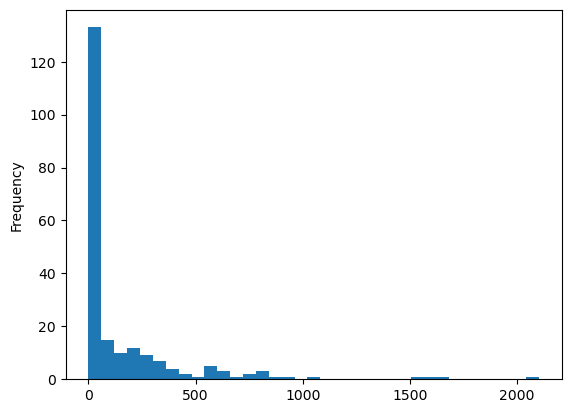

In [141]:
df_merged['count_rat_activity'].plot(
    kind='hist',
    bins = 35
)
#plt.show()

Something is wonky with the zipcodes that have over 1000 reported rodent sightings a month. This could be the result of a variety of factors including but not limited to: angry people filing complaints, the same rodent being sighted, or something else. Nonetheless, these are clearly outliers and won't provide useful insight into the analysis

In [96]:
df_merged = df_merged[df_merged['count_rat_activity'] <= 1000]

<Axes: ylabel='Frequency'>

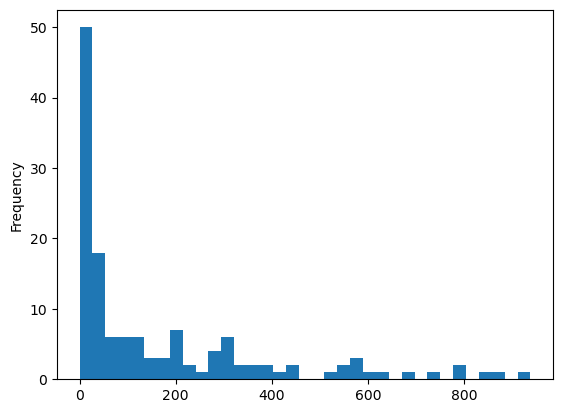

In [102]:
df_merged['count_rat_activity'].plot(
    kind='hist',
    bins = 35
)

Let's look at the restaurant score data

<Axes: ylabel='Frequency'>

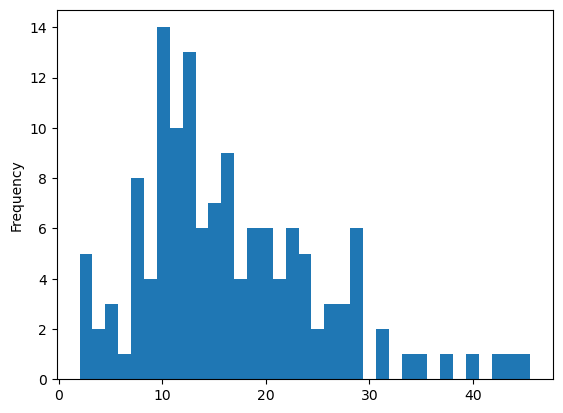

In [105]:
df_merged['SCORE'].plot(
    kind='hist',
    bins = 35
)

Looks normal enough. No aggregeous outliers

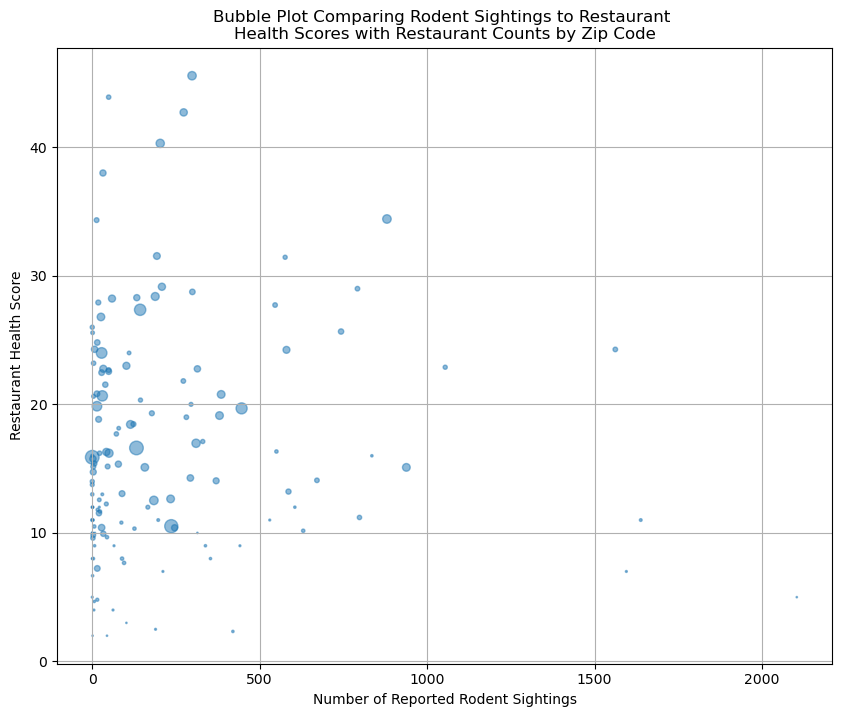

In [148]:
plt.figure(figsize=(10, 8))
plt.scatter(df_merged['count_rat_activity'], df_merged['SCORE'], s=df_merged['count_restaurants'], alpha=0.5)

# Add labels and title
plt.title('Bubble Plot Comparing Rodent Sightings to Restaurant \nHealth Scores with Restaurant Counts by Zip Code')
plt.xlabel('Number of Reported Rodent Sightings')
plt.ylabel('Restaurant Health Score')

# Add zip code annotations
#for i, row in df_merged.iterrows():
#    plt.annotate(row['ZIP_CODE'], (row['count_rat_activity'], row['SCORE']), fontsize=10, ha='center')

plt.grid(True)
plt.show()

Looking at this briefly, where the size of the bubble is how many restaurants are in that zip code, there does not appear to be meaningful relationship, but let's see if we can empirically prove that

## Regression Time
We're going to use a variety of: 
1) Generalized Linear model 
2) Robust regression
to try and deal with the right skewed rodent data

In [115]:
y = df_merged['SCORE']
X = df_merged['count_rat_activity']

In [116]:
model = sm.GLM(y, X, family=Poisson())
results = model.fit()

print(results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  SCORE   No. Observations:                  136
Model:                            GLM   Df Residuals:                      135
Model Family:                 Poisson   Df Model:                            0
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3429.3
Date:                Thu, 11 Jul 2024   Deviance:                       6246.0
Time:                        21:05:27   Pearson chi2:                 2.31e+04
No. Iterations:                     7   Pseudo R-squ. (CS):         -9.184e+17
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
count_rat_activity     0.0048   5.68

In [117]:
model = sm.RLM(y, X)
results = model.fit()

print(results.summary())

                    Robust linear Model Regression Results                    
Dep. Variable:                  SCORE   No. Observations:                  136
Model:                            RLM   Df Residuals:                      135
Method:                          IRLS   Df Model:                            0
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Thu, 11 Jul 2024                                         
Time:                        21:06:11                                         
No. Iterations:                     7                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
count_rat_activity     0.0396      0

## Results

What we can conclude from these regressions is that there is a statistically significant, but non-meaningful relationship between average restaurant health score in a zipcode and number of reported rodent sightings in a zipcode. For every extra reported roent sighting in a zip code, we expect a 0.0396 increase in average restaurant health score. In other words, for every extra 30 reported rodent sightings in a zipcode, we expect the average restaurant health score to go up by 1. Given that an 'A' rating is a score between 0 and 13, it would appear that these results while significantly significant, are indicative of no relationship.

Future research could use a different metric for zipcode cleanliness (or create a better estimate for rodents present in a zipcode since NYC's dataset is self reported). Additionally, it might be interesting to look at economic status of a zipcode, for we would assume that higher income areas have cleaner restaurants. Perhaps the definition of area should be moved from the arbitrary zipcode (which is maintained by the USPS for it's own purposes) to something more indicative of neighborhood lines. Relating to this, clustering the restaurants using a K-Nearest Neighbor algorithm might be a good approach (I don't have the computational power for this). 

Maybe with the new trash can policy this will all be moot? Who knows.